In [164]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import itertools

In [165]:
#Set up the initial files to be read

df_d = pd.read_csv('descarteIndex_m50.csv')
df_in = pd.read_csv('descarteIndex_m50Index.csv')
df_cases = pd.read_csv('caseInformation_States.csv')
df_safe = pd.read_csv('SafeGraphData.csv')
df_new_cases = pd.read_csv('newcases.csv')

In [166]:
#Create a list where all of the data is sorted by state- the data we were given included county data, but we 
#ignored that in favor of viewing the overall new cases by state. I used the fips data to sort by state, since admin
#was equal to 1 for all states at the state-level

def sort_by_state(df):
    df_list = []
    
    i = 1
    while i <= 56:
        df_temp = df.loc[df['fips'] == i]
        if len(df_temp) > 0:
            df_list.append(df_temp)
        i += 1
        
    return df_list

In [167]:
#A function to smooth data from new_cases and append it to every state (it takes in a sorted list)
# This function is specifically for the cases data
def smooth_data(df_list):
    i = 0
    while i < len(df_list):
        df_list[i]['smoothed_data'] = df_list[i]['new_cases'].rolling(14).mean()
        i += 1
    return df_list

In [168]:
#A function to smooth data from mobility and append it to every state (it takes in a sorted list)
# This function is specifically for the mobility data
def smooth_data2(df_list):
    i = 0
    while i < len(df_list):
        df_list[i]['smoothed_data'] = df_list[i]['mobility'].rolling(14).mean()
        i += 1
    return df_list

In [169]:
#A function to plot two related lists (in this case, the smoothed cases and smoothed mobility) 
#and save it into a given folder under a given name
def plotting_two(smoothed_data1, smoothed_data2, folder):
    
    temp1 = smoothed_data1['date'].tolist()
    temp2 = smoothed_data2['date'].tolist()
    x_values1 = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in temp1]
    y_values1 = smoothed_data1['smoothed_data'].tolist()
    x_values2 = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in temp2]
    y_values2 = smoothed_data2['smoothed_data'].tolist()
    
    fig, ax1 = plt.subplots() 
  
    color = 'tab:red'
    ax1.set_xlabel('Date') 
    ax1.set_ylabel('Cases', color = color) 
    ax1.plot(x_values1, y_values1, color = color) 
    ax1.tick_params(axis ='y', labelcolor = color) 
  
    ax2 = ax1.twinx() 
  
    color = 'tab:green'
    ax2.set_ylabel('Mobility', color = color) 
    ax2.plot(x_values2, y_values2, color = color) 
    ax2.tick_params(axis ='y', labelcolor = color) 
    
    state = smoothed_data2['state'].iloc[0]
    plt.title(state)
    plt.savefig(folder + '/' + state +  '.png')
    plt.show()
    

In [170]:
#A function to break my data for each state into months for piecemeal correlation- requires a list of data (broken up
#into state) as well as a start-date and end-date. I'm sure there's a neater way to do this, but I haven't worked much
#with the python date-time type before.

def break_into_months(data,start_date,end_date):
    temp_df = pd.DataFrame()
    
    mask = (data['date'] > start_date) & (data['date'] <= end_date)
    
    temp_df = data.loc[mask]
    
    return temp_df

In [171]:
#Sort the input dataframes by month
df_list_mobility = sort_by_state(df_d)
list_of_df = sort_by_state(df_cases)

In [172]:
state_names = df_new_cases["state"].tolist()
states = np.array(state_names)
states_condensed = np.unique(states)

In [173]:
#Needed to calculate the new cases since the data given was total cases
i = 0

while i < len(list_of_df):
    difference = list_of_df[i]["cases"].diff(periods=2)
    list_of_df[i]["new_cases"] = difference
    i+=1

<ipython-input-173-ca03bf4d8792>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_of_df[i]["new_cases"] = difference


In [174]:
#Here I needed to move around the table a bit- all of the mobilities were in one row with each individual day 
#as the column. I needed to work around it and fill state with the name of each state, have date and mobility be 
#two columns, and keep date and mobility at the correct index.

df_list = df_list_mobility
i = 0

mobility_list = []
list_index = []
while i < len(df_list):
    col = df_list[i].columns.tolist()  
    col = col[5:]
    
    index = df_list[i].index[0]
    
    val = df_list[i].loc[index, :].values.tolist()
    val = val[5:]
    
    temp_list = [df_list[i]['country_code'].values[0],df_list[i]['admin1'].values[0],df_list[i]['fips'].values[0]]
    temp_df = pd.DataFrame(columns = [])
    temp_df['date'] = col
    temp_df['mobility']= val
    temp_df['state']= temp_list[1]
        
    mobility_list.append(temp_df)
    list_index.append(temp_list)
    i += 1

In [175]:
#I smoothed the data- I didn't need to create a new list, but it helped me keep track of where I was in the program.
smoothed_list = smooth_data(list_of_df)
smoothed_list2 = smooth_data2(mobility_list)

<ipython-input-167-51796789e70c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[i]['smoothed_data'] = df_list[i]['new_cases'].rolling(14).mean()


In [176]:
#Again, there's probably a neater way to do this
#Breaking the mobility up into months
final_list = []
i = 0

while i < len(smoothed_list):
    final_list.append(break_into_months(smoothed_list[i],'2020-01-01', '2020-01-31'))
    final_list.append(break_into_months(smoothed_list[i],'2020-02-01', '2020-02-31'))
    final_list.append(break_into_months(smoothed_list[i],'2020-03-01', '2020-03-31'))
    final_list.append(break_into_months(smoothed_list[i],'2020-04-01', '2020-04-31'))
    final_list.append(break_into_months(smoothed_list[i],'2020-05-01', '2020-05-31'))
    final_list.append(break_into_months(smoothed_list[i],'2020-06-01', '2020-06-31'))
    final_list.append(break_into_months(smoothed_list[i],'2020-07-01', '2020-07-31'))
    final_list.append(break_into_months(smoothed_list[i],'2020-08-01', '2020-08-31'))
    final_list.append(break_into_months(smoothed_list[i],'2020-09-01', '2020-09-31'))
    final_list.append(break_into_months(smoothed_list[i],'2020-10-01', '2020-10-31'))
    final_list.append(break_into_months(smoothed_list[i],'2020-11-01', '2020-11-31'))
    final_list.append(break_into_months(smoothed_list[i],'2020-12-01', '2020-12-31'))
    final_list.append(break_into_months(smoothed_list[i],'2021-01-01', '2021-01-31'))
    final_list.append(break_into_months(smoothed_list[i],'2021-02-01', '2021-02-31'))
    final_list.append(break_into_months(smoothed_list[i],'2021-03-01', '2021-03-31'))
    final_list.append(break_into_months(smoothed_list[i],'2021-04-01', '2021-04-31'))
    i += 1

In [177]:
#Breaking the cases up into months
final_list2 = []
i = 0

while i < len(smoothed_list2):
    final_list2.append(break_into_months(smoothed_list2[i],'2020-01-01', '2020-01-31'))
    final_list2.append(break_into_months(smoothed_list2[i],'2020-02-01', '2020-02-31'))
    final_list2.append(break_into_months(smoothed_list2[i],'2020-03-01', '2020-03-31'))
    final_list2.append(break_into_months(smoothed_list2[i],'2020-04-01', '2020-04-31'))
    final_list2.append(break_into_months(smoothed_list2[i],'2020-05-01', '2020-05-31'))
    final_list2.append(break_into_months(smoothed_list2[i],'2020-06-01', '2020-06-31'))
    final_list2.append(break_into_months(smoothed_list2[i],'2020-07-01', '2020-07-31'))
    final_list2.append(break_into_months(smoothed_list2[i],'2020-08-01', '2020-08-31'))
    final_list2.append(break_into_months(smoothed_list2[i],'2020-09-01', '2020-09-31'))
    final_list2.append(break_into_months(smoothed_list2[i],'2020-10-01', '2020-10-31'))
    final_list2.append(break_into_months(smoothed_list2[i],'2020-11-01', '2020-11-31'))
    final_list2.append(break_into_months(smoothed_list2[i],'2020-12-01', '2020-12-31'))
    final_list2.append(break_into_months(smoothed_list2[i],'2021-01-01', '2021-01-31'))
    final_list2.append(break_into_months(smoothed_list2[i],'2021-02-01', '2021-02-31'))
    final_list2.append(break_into_months(smoothed_list2[i],'2021-03-01', '2021-03-31'))
    final_list2.append(break_into_months(smoothed_list2[i],'2021-04-01', '2021-04-31'))
    i += 1

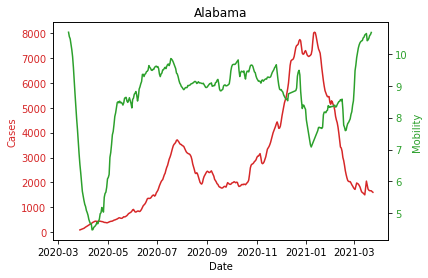

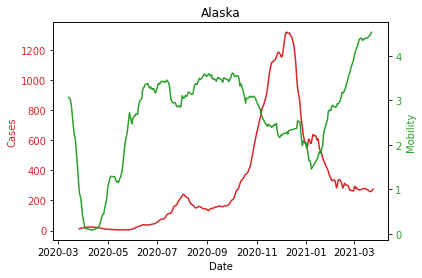

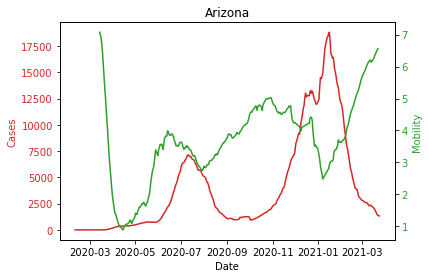

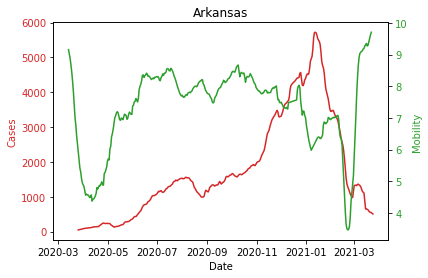

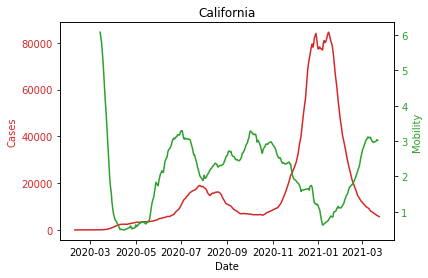

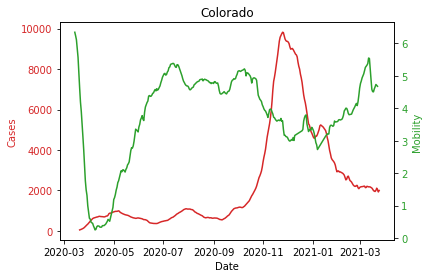

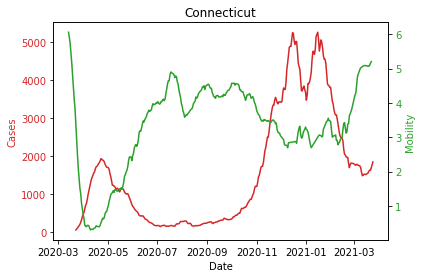

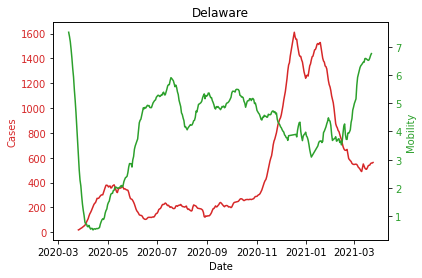

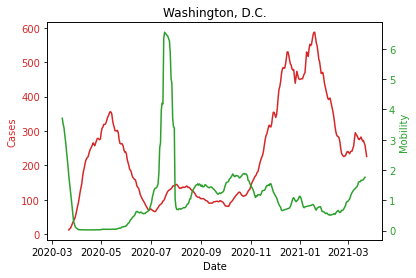

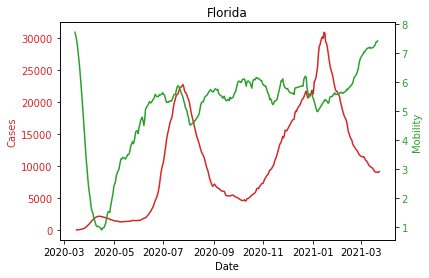

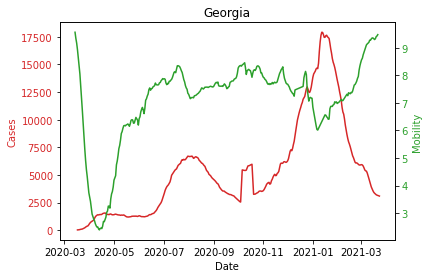

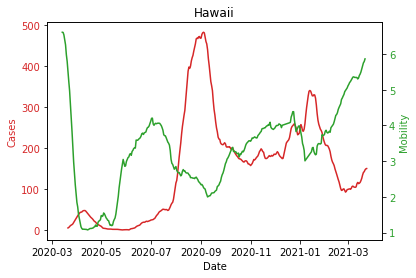

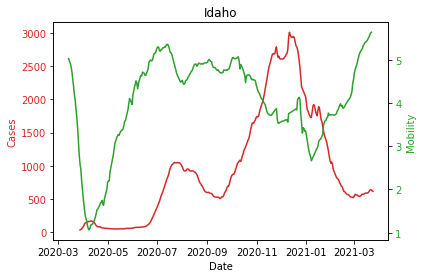

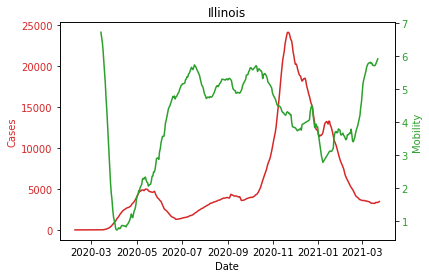

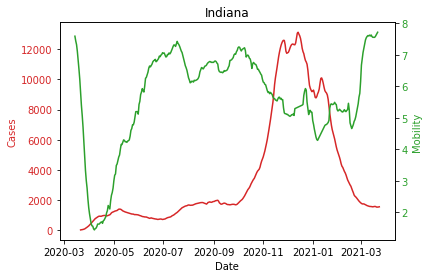

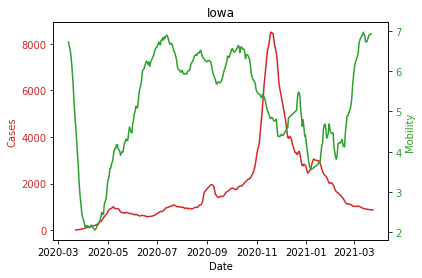

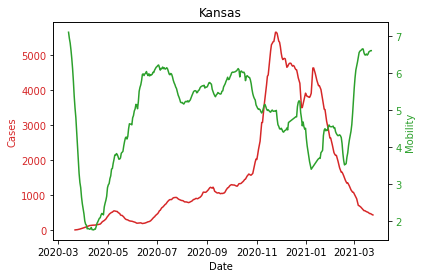

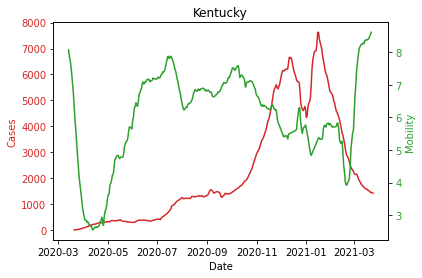

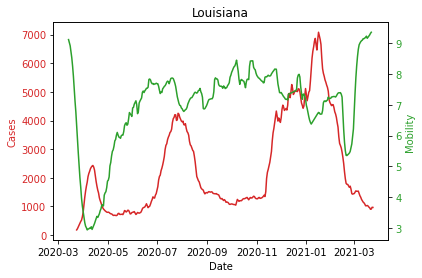

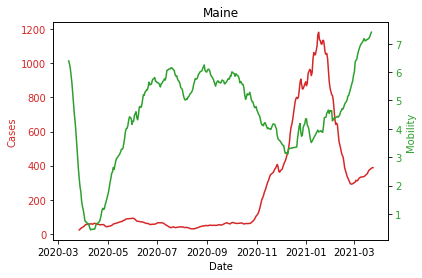

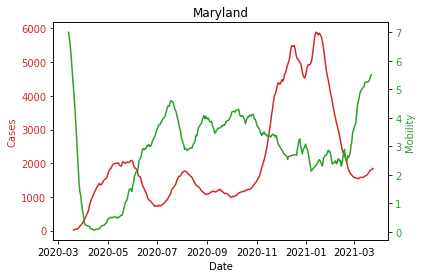

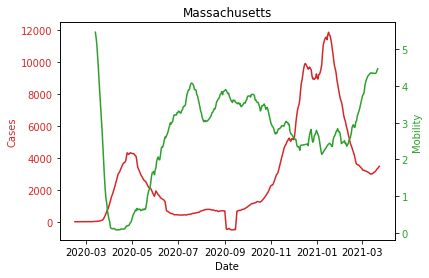

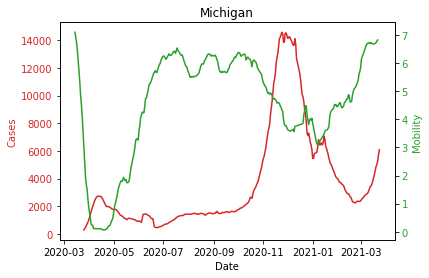

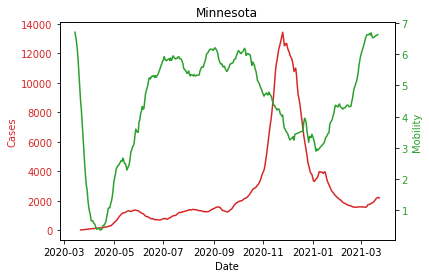

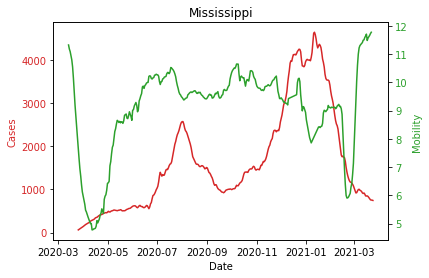

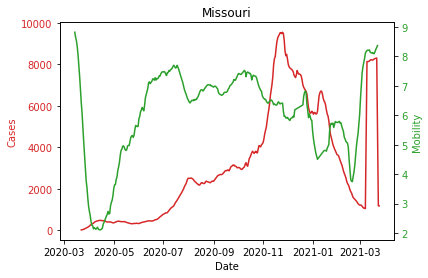

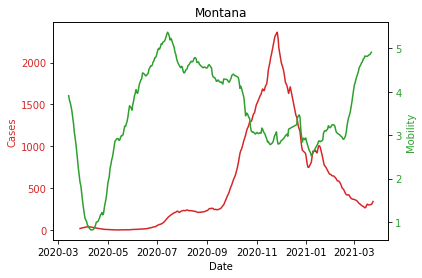

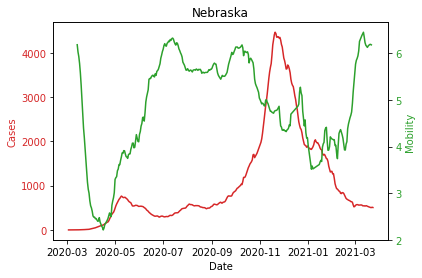

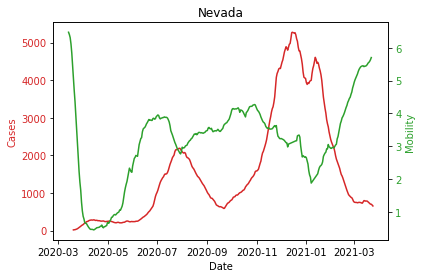

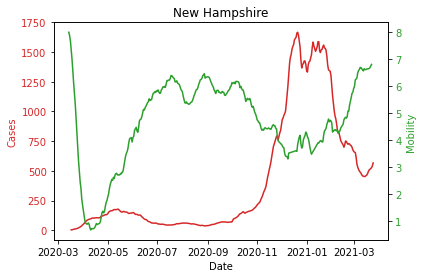

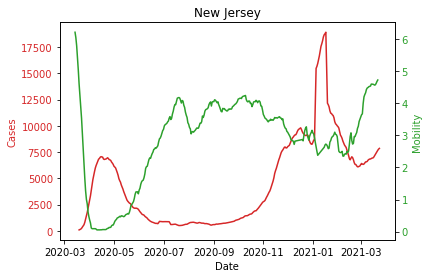

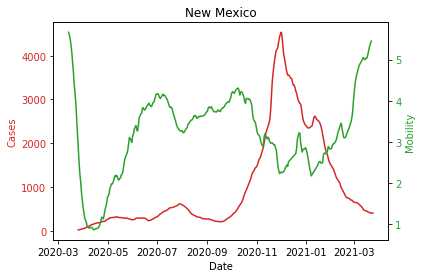

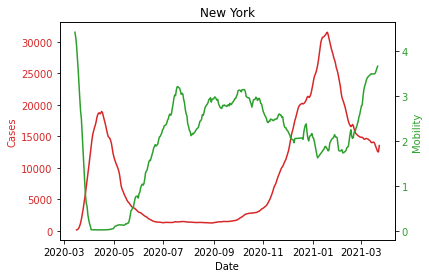

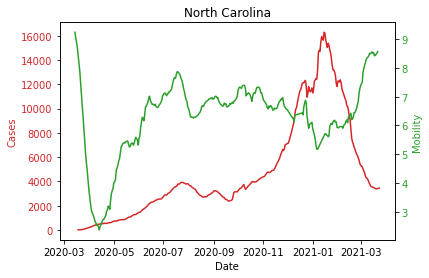

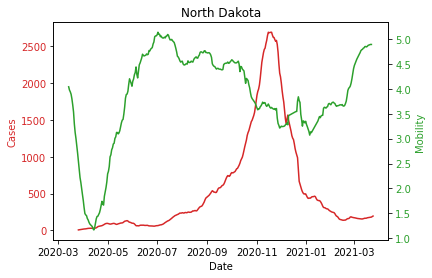

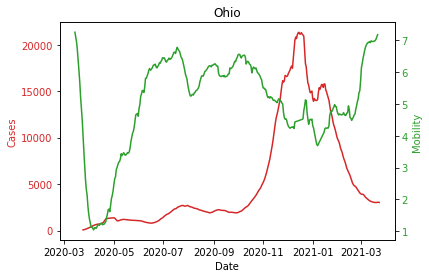

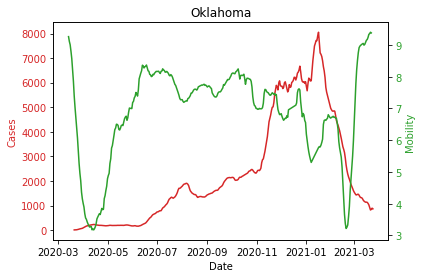

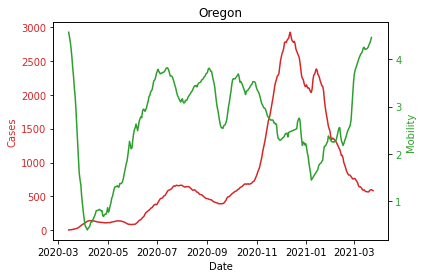

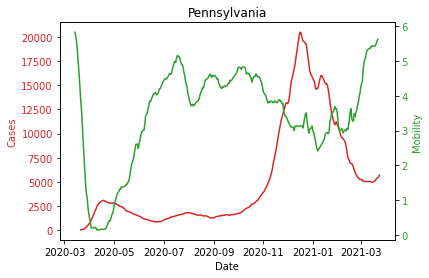

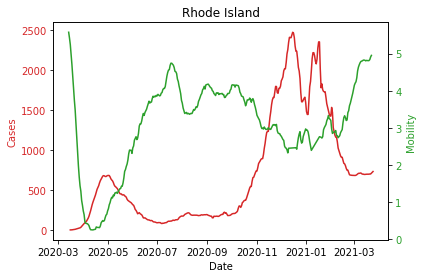

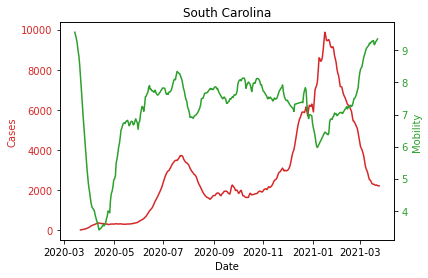

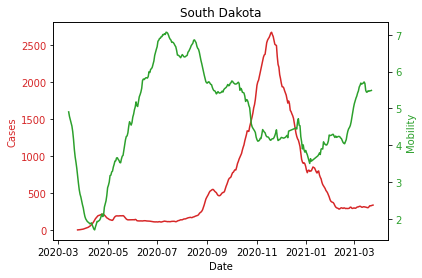

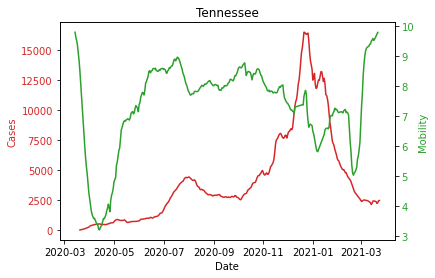

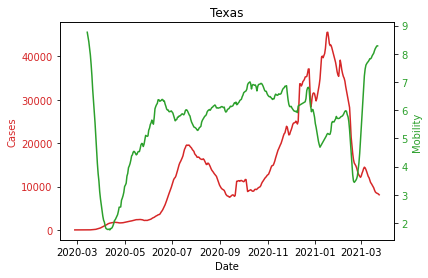

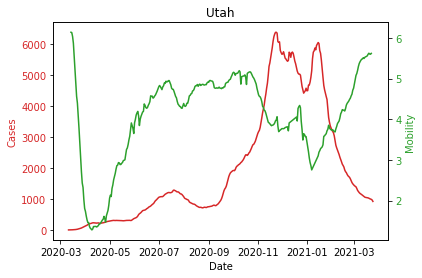

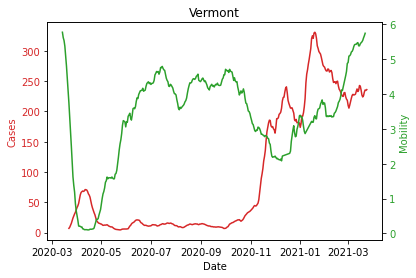

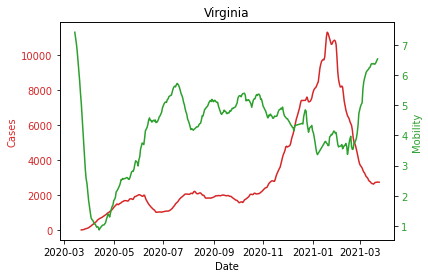

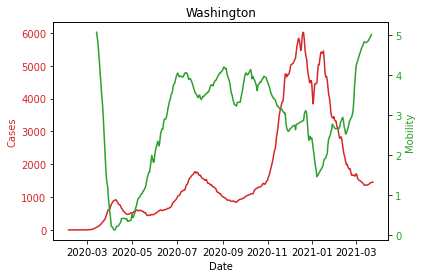

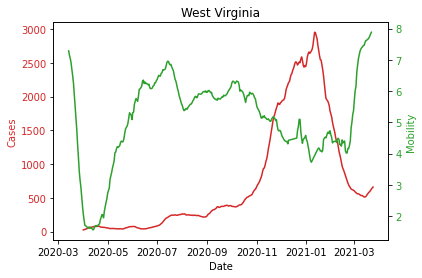

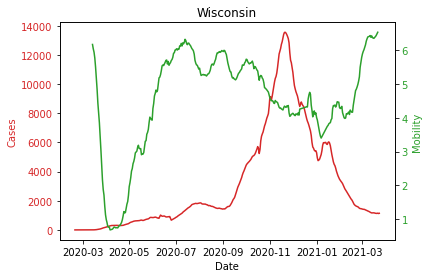

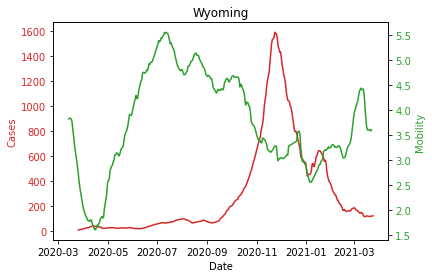

In [178]:
#new cases with mob50- plot all and save to file
i = 0

while i < len(smoothed_list2):
    
    plotting_two(smoothed_list[i],smoothed_list2[i], 'mob50')
    i += 1

In [179]:
#Months that didn't have mobility or case data need to be removed
empty_rem = []
empty_rem2 = []
i = 0
while i < len(final_list):
    if len(final_list[i]) > 0 and len(final_list2[i])> 0:
        empty_rem.append(final_list[i])
        empty_rem2.append(final_list2[i])
    i+=1

final_list = empty_rem
final_list2 = empty_rem2

In [180]:
#Creating my correlation matrices- I needed to take out some things for plotting reasons, but I also needed to 
#merge my dataframes on the Date column and then drop any extras. I created a list of the merged dataframes and
#stored the matrices as well

i = 0

results = []
date_merge_list = []
dates = []
states = []
corr_pairs = []
while i < len(final_list):
    if len(final_list[i]) > 0:
        mobility = final_list2[i]['smoothed_data']    
        date = final_list2[i]['date'].values.tolist() #Saving the dates for plotting reasons
        dates.append(date)
        state = final_list2[i]['state'].values.tolist() #Saving the states for plotting reasons
        states.append(state)
    
        temp_date = pd.merge(final_list[i], final_list2[i], on="date")
        temp_date.drop('cases', inplace=True, axis=1)
        temp_date.drop('deaths', inplace=True, axis=1)
        temp_date.rename(columns={"smoothed_data_x": "smoothed_data_cases", "smoothed_data_y": "smoothed_data_mobility"}, inplace=True)
        temp = temp_date.corr()
        temp_corr = temp.unstack()
        results.append(temp)
        sorted_pairs = temp_corr.sort_values(kind="quicksort")
        corr_pairs.append(sorted_pairs)
        date_merge_list.append(temp_date)
    i += 1
    

In [ ]:
#PLotted all my correlations and stored them in a folder, as well as correlations for smoothed data in a text file
file_object = open('correlations.txt', 'a')

i = 0
while i < len(results):
    f = plt.figure(figsize=(19, 15))
    plt.matshow(results[i], fignum=f.number)
    plt.xticks(range(date_merge_list[i].select_dtypes(['number']).shape[1]), date_merge_list[i].select_dtypes(['number']).columns, fontsize=14, rotation=45)
    plt.yticks(range(date_merge_list[i].select_dtypes(['number']).shape[1]), date_merge_list[i].select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix for '+ states[i][0]+ ' ' +dates[i][0][5:7]+' '+dates[i][0][0:4], fontsize=16);
    plt.savefig('correlations' + '/' + states[i][0] + '_'+dates[i][0][5:7]+' '+ dates[i][0][0:4]+'.png')
    plt.show()
    print(i)
    file_object.write('Correlations for '+ states[i][0]+ ' ' +dates[i][0][5:7]+' '+dates[i][0][0:4]+' = ' +str(results[i]['smoothed_data_cases']['smoothed_data_mobility'])+'\n')
    i+=1
    
file_object.close()